### Input dataset

In [1]:
import pandas as pd
import numpy as np


In [2]:
#Fetching input image dataset from fer2013.csv
image_data = pd.read_csv('/Users/sumitha/Documents/ProjectDeepLearning/Capstone_FER/fer2013.csv' )

In [3]:
#Number of images in the image dataset and the shape of the dataset
print('\nShape of the dataset : ',str(image_data.shape),"\n")


Shape of the dataset :  (35887, 3) 



In [4]:
#View first 10 image dataset values
image_data[0:10]

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
5,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
6,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
7,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
8,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training
9,2,255 254 255 254 254 179 122 107 95 124 149 150...,Training


In [5]:
#Determining the unique values in "Usage" of the image dataset
usage = np.unique(image_data["Usage"].values.ravel())
print('\nThe image dataset is split into ', str(usage))


The image dataset is split into  ['PrivateTest' 'PublicTest' 'Training']


In [6]:
print('\nNumber of images in dataset')
print('Training dataset   : ',str(len(image_data[image_data.Usage == "Training"])))
print('Private Test dataset    : ',str(len(image_data[image_data.Usage == "PrivateTest"])))
print('Public Test dataset : ',str(len(image_data[image_data.Usage == "PublicTest"])))


Number of images in dataset
Training dataset   :  28709
Private Test dataset    :  3589
Public Test dataset :  3589


### Training dataset summary

In [7]:
training_data = image_data[image_data.Usage == "Training"]
print('\nTraining set summary')
print('Angry   : ',str(len(training_data[training_data.emotion == 0])))
print('Fear    : ',str(len(training_data[training_data.emotion == 1])))
print('Disgust : ',str(len(training_data[training_data.emotion == 2])))
print('Happy   : ',str(len(training_data[training_data.emotion == 3])))
print('Sad     : ',str(len(training_data[training_data.emotion == 4])))
print('Surprise: ',str(len(training_data[training_data.emotion == 5])))
print('Neutral : ',str(len(training_data[training_data.emotion == 6])))


Training set summary
Angry   :  3995
Fear    :  436
Disgust :  4097
Happy   :  7215
Sad     :  4830
Surprise:  3171
Neutral :  4965


In [8]:
training_data = image_data[image_data.Usage == "Training"]
#Return the array as python list
image_pixels = training_data.pixels.str.split(" ").tolist()
image_pixels = pd.DataFrame(image_pixels, dtype=int)
images = image_pixels.values
#Changing numpy array to float
training_images = images.astype(np.float)
training_images

array([[ 70.,  80.,  82., ..., 106., 109.,  82.],
       [151., 150., 147., ..., 193., 183., 184.],
       [231., 212., 156., ...,  88., 110., 152.],
       ...,
       [ 74.,  81.,  87., ..., 188., 187., 187.],
       [222., 227., 203., ..., 136., 136., 134.],
       [195., 199., 205., ...,   6.,  15.,  38.]])

In [9]:
import matplotlib.pyplot as plt
#Plotting the input images
fig = plt.figure(figsize=(8, 8))
columns = 5
rows = 5
for i in range(1, columns*rows + 1):
    show_image = training_images[i-1].reshape(48, 48)
    fig.add_subplot(rows, columns, i)
    plt.imshow(show_image, cmap='gray')
    plt.savefig("input_overview.png")

### Image pre-processing

In [10]:
#Subtracting the mean value of each image
training_images = training_images - training_images.mean(axis=1).reshape(-1,1)

#Setting the image norm to be 100
training_images = np.multiply(images,100.0/255.0)
pixel_mean = training_images.mean(axis=0)
pixel_std = np.std(training_images, axis=0)
images = np.divide(np.subtract(training_images,pixel_mean), pixel_std)

print('\nImage shape : ',images.shape)

image_pixels = images.shape[1]
print('\nFlat pixel value : ',image_pixels)

image_width = image_height = np.ceil(np.sqrt(image_pixels)).astype(np.uint8)

print('\nImage width : ', image_width)

flat_labels = training_data["emotion"].values.ravel()
labels_count = np.unique(flat_labels).shape[0]
print('Number of facial expressions : ', labels_count)
#One hot encoding for emotion classes
def dense_to_one_hot_encoding(dense_labels, num_emotions):
    num_labels = dense_labels.shape[0]
    index_offset = np.arange(num_labels) * num_emotions
    labels_one_hot_encoding = np.zeros((num_labels, num_emotions))
    labels_one_hot_encoding.flat[index_offset + dense_labels.ravel()] = 1
    return labels_one_hot_encoding
labels = dense_to_one_hot_encoding(flat_labels, labels_count)
labels = labels.astype(np.uint8)



Image shape :  (28709, 2304)

Flat pixel value :  2304

Image width :  48
Number of facial expressions :  7


### Training a CNN Model

In [11]:
# Splitting data into training & validation to reduce overfitting
validation_size = 3709
validation_images = images[:validation_size]
validation_labels = labels[:validation_size]
train_images = images[validation_size:]
train_labels = labels[validation_size:]
print('Number of images in final training dataset : ', (len(train_images)))


Number of images in final training dataset :  25000


In [12]:
import tensorflow as tf

# Constructs a two-dimensional convolutional layer. 
def conv2d(x, W, padd):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding=padd)

# Constructs a two-dimensional pooling layer using the max-pooling algorithm.
def max_pool_2x2(x):
    return tf.nn.max_pooling(x, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='SAME')

In [13]:

# Constructs a two-dimensional convolutional layer. 
def conv2d(x, W, padd):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding=padd)

# Constructs a two-dimensional pooling layer using the max-pooling algorithm.
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='SAME')

# Creating placeholder for image data
x = tf.placeholder('float', shape=[None, image_pixels])
# Creating placeholder for labels
y_ = tf.placeholder('float', shape=[None, labels_count])

# First convolutional layer
W1_conv = tf.Variable(tf.truncated_normal(shape=[5, 5, 1, 64], stddev=1e-4, name = "W1_conv"))
bias1_conv = tf.Variable(tf.constant(0.1, shape=[64], name = "bias1_conv"))

# Reshaping the image data - (27000, 2304) --> (27000,48,48,1)
image = tf.reshape(x, [-1,image_width , image_height,1])

# h_conv1.get_shape() = (27000,48,48,64)
h_conv1 = tf.nn.relu(conv2d(image, W1_conv, "SAME") + bias1_conv)

#h_pool1.get_shape() = (27000,24,24,1)
h_pool1 = max_pool_2x2(h_conv1)
h_norm1 = tf.nn.lrn(h_pool1, 4, bias=1.0, alpha=0.001/9.0, beta=0.75)

# Second convolution layer
W2_conv = tf.Variable(tf.truncated_normal(shape=[5, 5, 64, 128], stddev=1e-4, name = "W2_conv"))
bias2_conv = tf.Variable(tf.constant(0.1, shape=[128], name = "bias2_conv"))

#h_conv2.get_shape() = (27000,24,24,128)
h_conv2 = tf.nn.relu(conv2d(h_norm1, W2_conv, "SAME") + bias2_conv)

h_norm2 = tf.nn.lrn(h_conv2, 4, bias=1.0, alpha=0.001/9.0, beta=0.75)
h_pool2 = max_pool_2x2(h_norm2)

# Densely connected local layer 3
W_fc1 = tf.Variable(tf.truncated_normal(shape=[12 * 12 * 128, 3072],stddev=0.04,name="W_fc1"))
b_fc1 = tf.Variable(tf.constant(0.0,shape=[3072], name = "b_fc1"))

# (27000, 12, 12, 128) -> (27000, 12 * 12 * 128)
h_pool2_flat = tf.reshape(h_pool2, [-1, 12 * 12 * 128])
#h_fc1.get_shape() = (27000, 1024)
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

# Densely connected layer local 4
W_fc2 = tf.Variable(tf.truncated_normal(shape=[3072, 1536], stddev=0.04,name="W_fc2"))
b_fc2 = tf.Variable(tf.constant(0.0, shape=[1536],name="b_fc2"))

#  (40000, 7, 7, 64) -> (40000, 3136)
h_fc2_flat = tf.reshape(h_fc1, [-1, 3072])
#h_fc1.get_shape() -> (40000, 1024)
h_fc2 = tf.nn.relu(tf.matmul(h_fc2_flat, W_fc2) + b_fc2)

# Dropout
keep_prob = tf.placeholder('float')
h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

# Readout layer for deep net
W_fc3 = tf.Variable(tf.truncated_normal(shape=[1536, labels_count],stddev=0.04,name="W_fc3"))
b_fc3 = tf.Variable(tf.constant(0.0, shape=[labels_count],name="b_fc3"))
#Softmax layer
#y.get_shape() = (40000, 10)
y = tf.nn.softmax((tf.matmul(h_fc2_drop, W_fc3) + b_fc3),name = "Softmax")


In [14]:
# Settings for the training
LEARNING_RATE = 0.0001

# Cost function
cross_entropy = -tf.reduce_sum(y_*tf.log(y))
# Optimization using Adam optimizer
train_step = tf.train.AdamOptimizer(LEARNING_RATE).minimize(cross_entropy)
    
# Evaluation of the predicted labels
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))

accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))

# Prediction function
predict = tf.argmax(y,1)

# Set training iterations to 4500
TRAINING_ITERATIONS = 10000
DROPOUT = 0.5
BATCH_SIZE = 50

epochs_completed = 0
index_in_epoch = 0
num_examples = train_images.shape[0]


# Serving data by batches
def next_batch(batch_size):
    global train_images
    global train_labels
    global index_in_epoch
    global epochs_completed

    start = index_in_epoch
    index_in_epoch += batch_size

    # When all training data has been used, it is reordered randomly
    if index_in_epoch > num_examples:
        # Finished epoch
        epochs_completed += 1
        # Shuffle the data
        perm = np.arange(num_examples)
        np.random.shuffle(perm)
        train_images = train_images[perm]
        train_labels = train_labels[perm]
        # Start next epoch
        start = 0
        index_in_epoch = batch_size
        assert batch_size <= num_examples
    end = index_in_epoch
    return train_images[start:end], train_labels[start:end]



In [15]:
import tensorflow as tf
import datetime
# Starting TensorFlow session
#init = tf.initialize_all_variables()
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()
sess.run(init)
# Visualisation variables
train_accuracies = []
validation_accuracies = []
x_range = []
display_step=1

In [16]:
for i in range(TRAINING_ITERATIONS):

    # Get new batch
    batch_xs, batch_ys = next_batch(BATCH_SIZE)

    # Checking progress on every 1st,2nd,...,10th,20th,...,100th... step
    if i % display_step == 0 or (i + 1) == TRAINING_ITERATIONS:

        train_accuracy = accuracy.eval(feed_dict={x: batch_xs,
                                                  y_: batch_ys,
                                                  keep_prob: 1.0})
        if (validation_size):
            validation_accuracy = accuracy.eval(feed_dict={x: validation_images[0:BATCH_SIZE],
                                                           y_: validation_labels[0:BATCH_SIZE],
                                                           keep_prob: 1.0})
            print('Training accuracy :  %.2f  Validation accuracy :  %.2f  for step %d' % (
            train_accuracy, validation_accuracy, i))

            validation_accuracies.append(validation_accuracy)

        else:
            print('Training accuracy :  %.4f for step %d' % (train_accuracy, i))
        train_accuracies.append(train_accuracy)
        x_range.append(i)

        # Increasing display_step
        if i % (display_step * 10) == 0 and i and display_step < 100:
            display_step *= 10
    # Training on batch
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys, keep_prob: DROPOUT})
   

Training accuracy :  0.02  Validation accuracy :  0.00  for step 0
Training accuracy :  0.22  Validation accuracy :  0.24  for step 1
Training accuracy :  0.16  Validation accuracy :  0.22  for step 2
Training accuracy :  0.24  Validation accuracy :  0.10  for step 3
Training accuracy :  0.10  Validation accuracy :  0.10  for step 4
Training accuracy :  0.30  Validation accuracy :  0.24  for step 5
Training accuracy :  0.30  Validation accuracy :  0.24  for step 6
Training accuracy :  0.22  Validation accuracy :  0.24  for step 7
Training accuracy :  0.16  Validation accuracy :  0.18  for step 8
Training accuracy :  0.10  Validation accuracy :  0.18  for step 9
Training accuracy :  0.10  Validation accuracy :  0.18  for step 10
Training accuracy :  0.28  Validation accuracy :  0.24  for step 20
Training accuracy :  0.18  Validation accuracy :  0.24  for step 30
Training accuracy :  0.22  Validation accuracy :  0.24  for step 40
Training accuracy :  0.22  Validation accuracy :  0.24  fo

KeyboardInterrupt: 

In [17]:
print("Creating a saver object which will save all the variables")
saver = tf.train.Saver()
#sess.run(tf.global_variables_initializer())
print("# Saving the graph")
saver.save(sess, '/Users/sumitha/Documents/ProjectDeepLearning/cnn_model/my_model', global_step=9500)

Creating a saver object which will save all the variables
# Saving the graph


'/Users/sumitha/Documents/ProjectDeepLearning/cnn_model/my_model-9500'

Validation accuracy :  0.4864


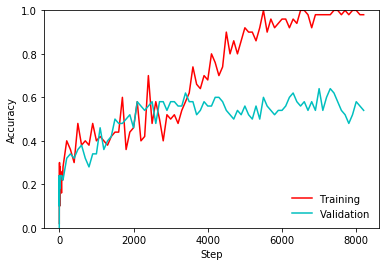

In [18]:
if(validation_size):
    validation_accuracy = accuracy.eval(feed_dict={x: validation_images,
                                                   y_: validation_labels,
                                                   keep_prob: 1.0})
    print('Validation accuracy :  %.4f'%validation_accuracy)
    plt.plot(x_range, train_accuracies,'-r', label='Training')
    plt.plot(x_range, validation_accuracies,'-c', label='Validation')
    plt.legend(loc='lower right', frameon=False)
    plt.ylim(ymax = 1.0, ymin = 0.0)
    plt.ylabel('Accuracy')
    plt.xlabel('Step')
    plt.show()
    plt.savefig("Training_val_accuracy.png")

In [19]:
test_data = image_data[image_data.Usage == "PublicTest"]
print(test_data[0:10])
image_pixels = test_data.pixels.str.split(" ").tolist()
image_pixels = pd.DataFrame(image_pixels, dtype=int)
test_images = image_pixels.values
test_images = test_images.astype(np.float)

       emotion                                             pixels       Usage
28709        0  254 254 254 254 254 249 255 160 2 58 53 70 77 ...  PublicTest
28710        1  156 184 198 202 204 207 210 212 213 214 215 21...  PublicTest
28711        4  69 118 61 60 96 121 103 87 103 88 70 90 115 12...  PublicTest
28712        6  205 203 236 157 83 158 120 116 94 86 155 180 2...  PublicTest
28713        3  87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...  PublicTest
28714        3  235 233 223 109 34 37 34 31 28 38 56 69 106 13...  PublicTest
28715        2  71 70 104 147 166 170 195 145 156 154 146 129 ...  PublicTest
28716        0  176 177 170 168 173 171 167 169 166 139 98 107...  PublicTest
28717        2  255 255 255 255 255 255 255 255 255 255 255 25...  PublicTest
28718        0  126 126 123 119 116 113 112 111 110 111 93 72 ...  PublicTest


In [20]:
#Image pre-orocessing
test_images = test_images - test_images.mean(axis=1).reshape(-1,1)
test_images = np.multiply(test_images,100.0/255.0)
each_pixel_mean = test_images.mean(axis=0)
each_pixel_std = np.std(test_images, axis=0)
test_images = np.divide(np.subtract(test_images,each_pixel_mean), each_pixel_std)
image_pixels = test_images.shape[1]
image_width = image_height = np.ceil(np.sqrt(image_pixels)).astype(np.uint8)

print('test_images({0[0]},{0[1]})'.format(test_images.shape))

test_images(3589,2304)


In [21]:
predicted_lables = np.zeros(test_images.shape[0])
for i in range(0,test_images.shape[0]//BATCH_SIZE):
    predicted_lables[i*BATCH_SIZE : (i+1)*BATCH_SIZE] = predict.eval(feed_dict={x: test_images[i*BATCH_SIZE : (i+1)*BATCH_SIZE], 
                                                                                keep_prob: 1.0})


print('predicted_lables({0})'.format(len(predicted_lables)))

predicted_lables(3589)


In [22]:
predicted_lables

array([2., 0., 4., ..., 0., 0., 0.])

In [23]:
test_data.emotion.values

array([0, 1, 4, ..., 4, 4, 4])

In [24]:
from sklearn.metrics import accuracy_score
accuracy_score(test_data.emotion.values, predicted_lables)

0.47645583728057955

In [25]:
#Defining a function to show image through 48*48 pixels
def show(img):
    show_image = img.reshape(48,48)
    plt.imshow(show_image, cmap='gray')

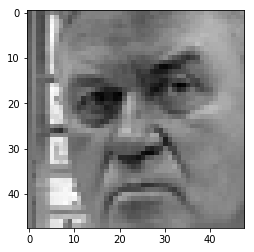

In [26]:
#show one image
show(test_images[2])

In [27]:
print(type(predicted_lables))
predicted_lables = predicted_lables.tolist()
print(type(predicted_lables))

<class 'numpy.ndarray'>
<class 'list'>


In [28]:
def plot_subjects(start, end,pred = []):
    iter = int((end - start)/6)
    for i in np.arange(0,iter):
        fig = plt.figure(figsize=(12,12))
        emotion = {0:'Angry', 1:'Fear', 2:'Disgust', 3: 'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}
        for j in range(i*6, (i+1)*6):
            ax = fig.add_subplot(6,6,j+1)
            ax.imshow(test_images[j].reshape(48,48),cmap='gray')
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))
            plt.xlabel(emotion[pred[j]], color='#53b3cb',fontsize=12)
            plt.tight_layout()
        plt.show()
        

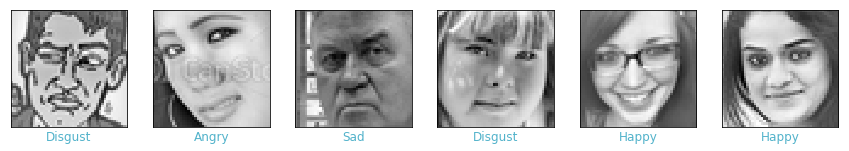

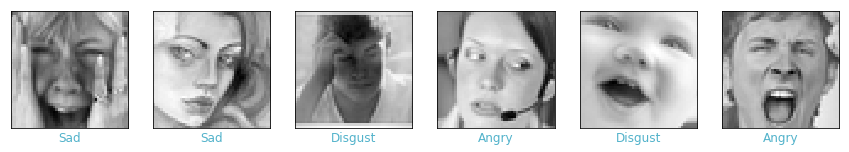

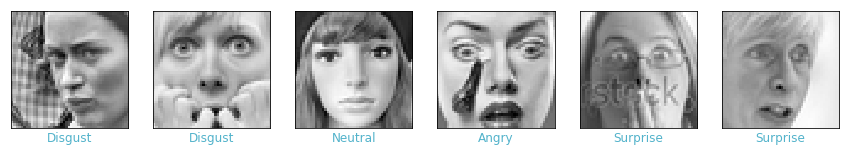

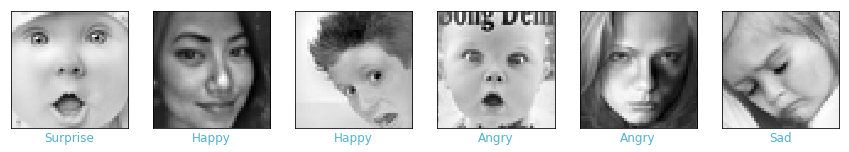

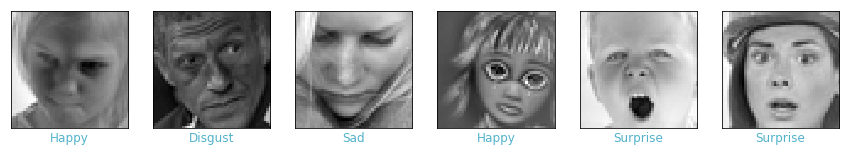

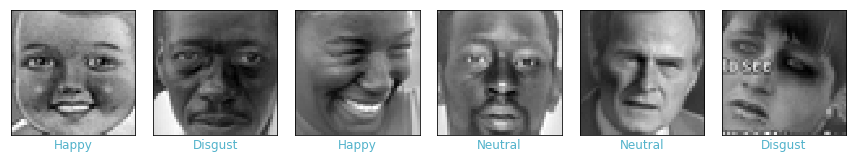

In [29]:
plot_subjects(0,36,predicted_lables)